### Notebook to examine the inverse barometer effect


As Dewi did this (https://github.com/dlebars/SLBudget/blob/master/code/SeaLevelContrib.py)


In [79]:
# Import necessary functions
import xarray as xr
import pandas as pd

# Declare path
path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Pressure/'
path_coords = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Coordinates/'

In [80]:
# Import data
pres_era5 = xr.open_dataset(path+'pres_annual_era5.nc')
pres_20cr = xr.open_dataset(path+'pres_annual_20cr.nc')

In [81]:
# Import tide gauge station coordinates
tg_coords = pd.read_csv(path_coords+'tgstations.csv', index_col='station')
tg_coords = tg_coords[:-1] # Remove average station

#### Compute IBE at tide gauge locations

In [82]:
def ibe_df(pressure):
    
    # Declare variables
    rho = 1030 # Density of ocean water
    g = 9.81 # Acceleration of gravity on Earth's surface
    
    
    df = pd.DataFrame({'time':pressure.year.values})
    df = df.set_index('time')
    
    for station in tg_coords.index:
        pres = pressure.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method='Nearest').pressure.values
        pres = pres - pres.mean() # Calculate anomaly while i have no idea why
        
        ibe = -pres/(rho*g)*100 # Inverse barometer effect in cm
        df[station] = ibe - ibe.mean() # Calculate anomaly?? again and save in DataFrame
        
    df['Average'] = df.mean(axis=1)
    
    return df

In [83]:
ibe_era5 = ibe_df(pres_era5)
ibe_20cr = ibe_df(pres_20cr)

<AxesSubplot:title={'center':'data = 20cr'}, xlabel='time [y]', ylabel='IBE [cm]'>

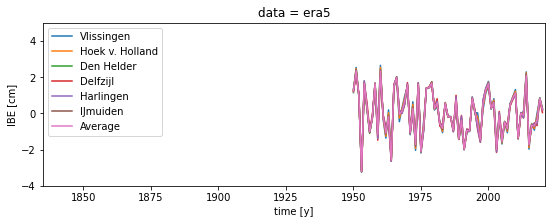

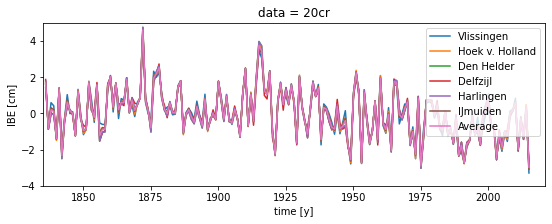

In [84]:
ibe_era5.plot(figsize=(9,3), ylabel = 'IBE [cm]', xlabel = 'time [y]', title = 'data = era5', 
              ylim = [-4,5], xlim = [1835, 2021])
ibe_20cr.plot(figsize=(9,3), ylabel = 'IBE [cm]', xlabel = 'time [y]', title = 'data = 20cr', 
              ylim = [-4,5], xlim = [1835, 2021])

I'm quite surprised that the IBE reaches between -4 and 4 cm. What will the wind contribution be if this effect is removed?

Not so much as this is just the trend but not the variability

<AxesSubplot:xlabel='time [y]', ylabel='SLH [cm]'>

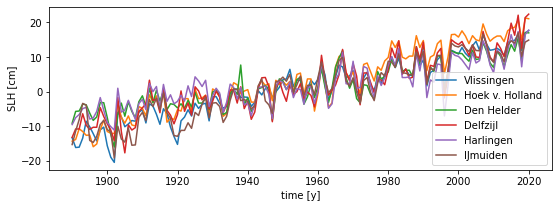

In [92]:
# Import tide gauge data
path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/tg_data.csv'
tg_data_df = pd.read_csv(path)
tg_data_df = tg_data_df.set_index('time').drop('Average', axis=1)
tg_data_df.plot(figsize=(9,3), ylabel = 'SLH [cm]', xlabel = 'time [y]')

But how to remove this inverse barometer effect from the tide gauge data since time series are different? That does not matter since for the regression only the overlapping time series are used so I can just remove the ibe before regressing

In [106]:
def remove_ibe(tg_data, ibe):
    
    # Create dataframes of equal time span
    tg_data = tg_data[tg_data.index.isin(ibe.index)]
    ibe = ibe[ibe.index.isin(tg_data.index)]
    
    df = pd.DataFrame({'time':tg_data.index.values})
    df = df.set_index('time')
    
    
    for station in tg_data.columns:
        removed = tg_data[station].values - ibe[station].values
        df[station] = removed
        
    return df

In [109]:
# Remove ibe from tide gauge data
tg_wh_ibe_era5 = remove_ibe(tg_data_df, ibe_era5)
tg_wh_ibe_20cr = remove_ibe(tg_data_df, ibe_20cr)

<AxesSubplot:title={'center':'Tide gauge data with 20cr ibe removed'}, xlabel='time [y]', ylabel='SLH [cm]'>

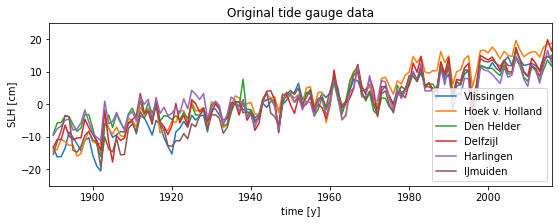

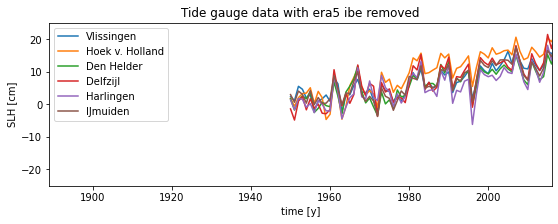

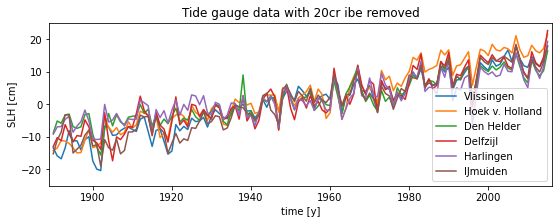

In [114]:
tg_data_df.plot(figsize=(9,3), ylabel = 'SLH [cm]', xlabel = 'time [y]', title = 'Original tide gauge data',
              ylim = [-25,25], xlim = [1889, 2016])
tg_wh_ibe_era5.plot(figsize=(9,3), ylabel = 'SLH [cm]', xlabel = 'time [y]', title = 'Tide gauge data with era5 ibe removed',
              ylim = [-25,25], xlim = [1889, 2016])
tg_wh_ibe_20cr.plot(figsize=(9,3), ylabel = 'SLH [cm]', xlabel = 'time [y]', title = 'Tide gauge data with 20cr ibe removed',
              ylim = [-25,25], xlim = [1889, 2016])

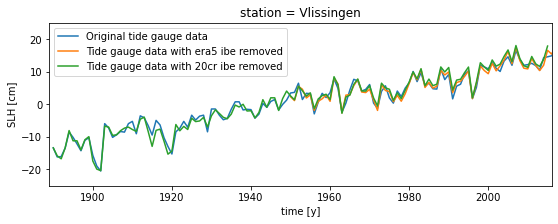

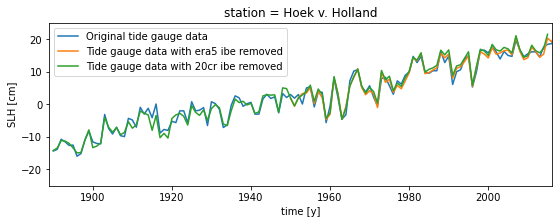

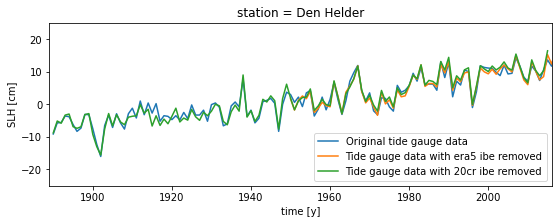

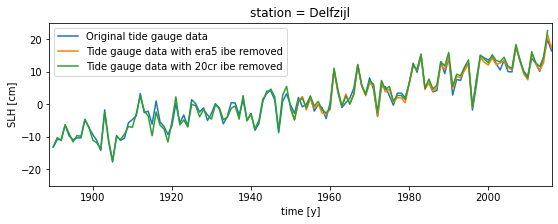

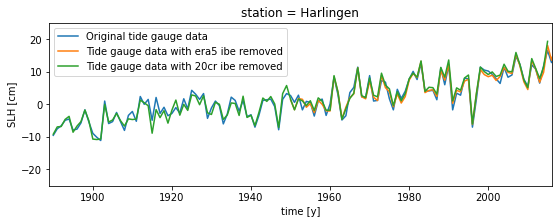

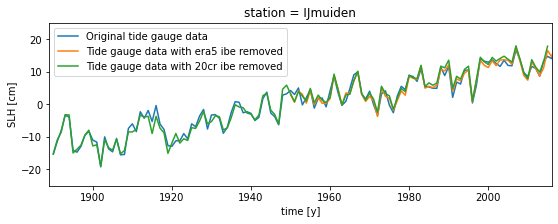

In [119]:
import matplotlib.pyplot as plt

for station in tg_data_df.columns:
    plt.figure(figsize=(9,3))
    plt.plot(tg_data_df.index, tg_data_df[station], label = 'Original tide gauge data')
    plt.plot(tg_wh_ibe_era5.index, tg_wh_ibe_era5[station], label = 'Tide gauge data with era5 ibe removed')
    plt.plot(tg_wh_ibe_20cr.index, tg_wh_ibe_20cr[station], label = 'Tide gauge data with 20cr ibe removed')
    plt.xlim(1889, 2016)
    plt.ylim(-25,25)
    plt.title(f'station = {station}')
    plt.xlabel('time [y]')
    plt.ylabel('SLH [cm]')
    plt.legend()

So how will I implement this in the analysis? In the regression function calculate the ibe and remove it from the tide gauge data after making both dataframes have an equal time span